## Imports and Config

In [1]:
!pip install folium
!pip instal tqdm

ERROR: unknown command "instal" - maybe you meant "install"



In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint
from matplotlib import pyplot as plt
import folium
from folium import plugins
from  tqdm import tqdm
tqdm.pandas(desc="Progress BAR!")

In [3]:
DATA_PATH = Path("../data")
all_csvs = list(DATA_PATH.glob("*.csv"))
pprint(all_csvs)

[WindowsPath('../data/hashtag_donaldtrump.csv'),
 WindowsPath('../data/hashtag_joebiden.csv')]


In [4]:
## Only pick these columns
USE_COLS = [
    'created_at', 'tweet', 'likes', 'retweet_count',
    'source','user_name', 'user_screen_name','user_followers_count', 'lat',
    'long', 'country', 'state'
]

## Number of rows to include from each CSV
N_ROWS = 800000

## Loading the data

In [5]:
trump = pd.read_csv(all_csvs[0],nrows=N_ROWS,usecols=USE_COLS,lineterminator="\n")
biden = pd.read_csv(all_csvs[1],nrows=N_ROWS,usecols=USE_COLS,lineterminator="\n")


In [6]:
trump.loc[:,'condidat'] = 'Trump'
biden.loc[:,'condidat'] = 'Biden'

In [7]:
df = pd.concat([trump,biden])

In [8]:
df.shape

(1576886, 13)

In [9]:
df.head()

,created_at,tweet,likes,retweet_count,source,user_name,user_screen_name,user_followers_count,lat,long,country,state,condidat
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,El Sol Latino News,elsollatinonews,1860.0,25.774270,-80.193660,United States of America,Florida,Trump
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,Tgcom24,MediasetTgcom24,1067661.0,NaN,NaN,NaN,NaN,Trump
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,snarke,snarke,1185.0,45.520247,-122.674195,United States of America,Oregon,Trump
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,Trumpytweeter,trumpytweeter,32.0,NaN,NaN,NaN,NaN,Trump
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,Rana Abtar - رنا أبتر,Ranaabtar,5393.0,38.894992,-77.036558,United States of America,District of Columbia,Trump


In [10]:
df.columns

Index(['created_at', 'tweet', 'likes', 'retweet_count', 'source', 'user_name',
       'user_screen_name', 'user_followers_count', 'lat', 'long', 'country',
       'state', 'condidat'],
      dtype='object')

In [11]:
df.isna().sum()

created_at                    0
tweet                         0
likes                         0
retweet_count                 0
source                     1508
user_name                    33
user_screen_name              0
user_followers_count          0
lat                      846924
long                     846924
country                  850897
state                   1045820
condidat                      0
dtype: int64

In [12]:
df.dropna(inplace=True)
df.isna().sum()

created_at              0
tweet                   0
likes                   0
retweet_count           0
source                  0
user_name               0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
country                 0
state                   0
condidat                0
dtype: int64

In [13]:
df.shape

(530857, 13)

In [14]:
biden.dropna(inplace=True)
biden.isna().sum()

created_at              0
tweet                   0
likes                   0
retweet_count           0
source                  0
user_name               0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
country                 0
state                   0
condidat                0
dtype: int64

In [15]:
trump.dropna(inplace=True)
trump.isna().sum()

created_at              0
tweet                   0
likes                   0
retweet_count           0
source                  0
user_name               0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
country                 0
state                   0
condidat                0
dtype: int64

In [16]:
biden.shape

(260117, 13)

In [17]:
trump.shape

(270740, 13)

# sentiment analysis

In [18]:
!pip install textblob

In [19]:
import io
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import plotly.graph_objects as go
from textblob import TextBlob
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words('english'))
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    filtered_tweet=[]
    words = word_tokenize(text) 
    for word in words:
        if not word in stop_words:
            filtered_tweet.append(word)
    return " ".join(filtered_tweet)

In [21]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
    
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

In [22]:
#Define Wordcloud method
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");


## Sentiment analysis Trump

In [23]:
trump_tweets = df.query('(condidat == "Trump")').sort_values('user_followers_count',ascending = False) #.drop_duplicates(['user_name'])[['tweet','country']]
trump_tweets = trump_tweets.dropna().loc[trump_tweets.country == 'United States of America']

trump_tweets.reset_index(inplace = True, drop = True)

trump_tweets['ClearTweet'] = trump_tweets['tweet'].progress_apply(clean)

trump_tweets['subjectivity']= trump_tweets['ClearTweet'].progress_apply(getSubjectivity)
trump_tweets['polarity']    = trump_tweets['ClearTweet'].progress_apply(getPolarity)
trump_tweets['analysis']    = trump_tweets['polarity'].progress_apply(getAnalysis)
trump_tweets.head()



Progress BAR!: 100%|██████████| 157080/157080 [00:00<00:00, 1158090.70it/s]


,created_at,tweet,likes,retweet_count,source,user_name,user_screen_name,user_followers_count,lat,long,country,state,condidat,ClearTweet,subjectivity,polarity,analysis
0,2020-10-20 22:52:44,"President Donald #Trump’s youngest daughter, T...",56.0,16.0,SocialNewsDesk,USA TODAY,USATODAY,4163175.0,40.463179,-88.819661,United States of America,Illinois,Trump,president donald trump youngest daughter tiffa...,0.000000,0.0,neutral
1,2020-10-27 03:00:18,Woah. Have you read this article?\n\nAll the p...,695.0,291.0,Twitter for iPhone,Alyssa Milano,Alyssa_Milano,3750110.0,34.053691,-118.242766,United States of America,California,Trump,woah read article president debts donald trump...,0.000000,0.0,neutral
2,2020-11-06 10:30:06,Actress #NatalieMorales explained why some Lat...,99.0,21.0,SocialFlow,The Hollywood Reporter,THR,3264524.0,34.098003,-118.329523,United States of America,California,Trump,actress nataliemorales explained latinx voters...,0.000000,0.0,neutral
3,2020-11-05 15:35:11,#JimmyKimmel offered his view about how the la...,73.0,1.0,SocialFlow,The Hollywood Reporter,THR,3264260.0,34.098003,-118.329523,United States of America,California,Trump,jimmykimmel offered view last day gone close r...,0.066667,0.0,neutral
4,2020-11-05 16:16:20,#SethMeyers lambastes Fox News for parroting #...,73.0,4.0,SocialFlow,The Hollywood Reporter,THR,3264260.0,34.098003,-118.329523,United States of America,California,Trump,sethmeyers lambastes fox news parroting donald...,0.000000,0.0,neutral


In [24]:
trump_tweets.shape

(157080, 17)

Text(0.5, 1.0, 'Dataset labels distribuition')

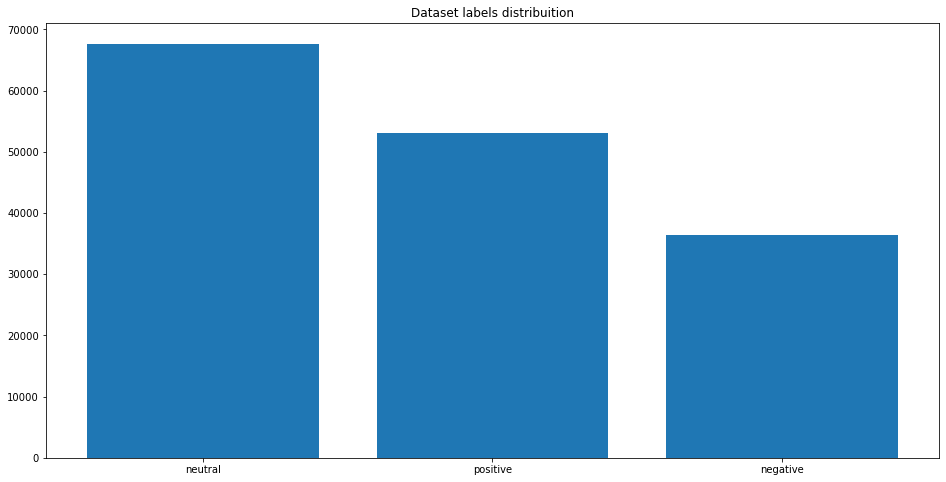

In [25]:
from collections import Counter

target_cnt = Counter(trump_tweets.analysis)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [26]:
general  = trump_tweets.groupby('analysis').analysis.count()
neutral  = trump_tweets[trump_tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = trump_tweets[trump_tweets['analysis'] == 'positive'].ClearTweet.count()
negative = trump_tweets[trump_tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positive","negative","neutral"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentiment analysis  Donald Trump Tweets')
fig.show()

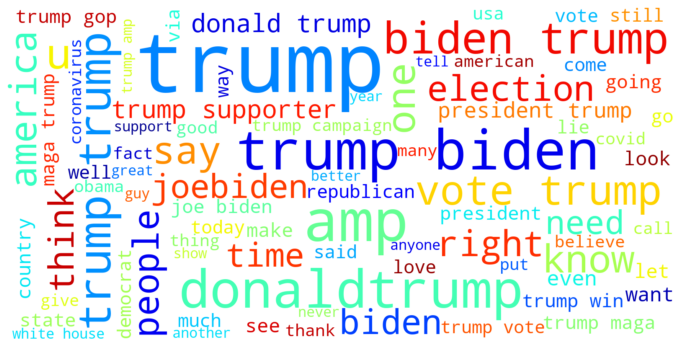

In [27]:
#Plot trump wordcloud
word_cloud(trump_tweets['ClearTweet'])

## Sentiment analysis Biden

In [28]:
biden_tweets = df.query('(condidat == "Biden")').sort_values('user_followers_count',ascending = False) #.drop_duplicates(['user_name'])[['tweet','country']]
biden_tweets = biden_tweets.dropna().loc[biden_tweets.country == 'United States of America']

biden_tweets.reset_index(inplace = True, drop = True)

biden_tweets['ClearTweet'] = biden_tweets['tweet'].progress_apply(clean)

biden_tweets['subjectivity']= biden_tweets['ClearTweet'].progress_apply(getSubjectivity)
biden_tweets['polarity']    = biden_tweets['ClearTweet'].progress_apply(getPolarity)
biden_tweets['analysis']    = biden_tweets['polarity'].progress_apply(getAnalysis)
biden_tweets.head()


Progress BAR!: 100%|██████████| 153577/153577 [00:00<00:00, 1140522.09it/s]


,created_at,tweet,likes,retweet_count,source,user_name,user_screen_name,user_followers_count,lat,long,country,state,condidat,ClearTweet,subjectivity,polarity,analysis
0,2020-10-25 17:13:14,#JoeBiden is enlisting A-list star power to he...,73.0,4.0,Twitter Web App,Perez Hilton,PerezHilton,5750841.0,34.053691,-118.242766,United States of America,California,Biden,joebiden enlisting list star power help close ...,0.0000,0.00000,neutral
1,2020-11-07 18:53:10,Celebs are just as excited as we are that Amer...,226.0,14.0,Hootsuite Inc.,Perez Hilton,PerezHilton,5747840.0,34.053691,-118.242766,United States of America,California,Biden,celebs excited america voted blue congrats pre...,0.6625,0.49375,positive
2,2020-11-08 20:19:52,While we were campaigning across battleground ...,717.0,55.0,Twitter Media Studio,COMMON,common,5477365.0,41.875562,-87.624421,United States of America,Illinois,Biden,campaigning across battleground states ran gre...,0.7500,0.80000,positive
3,2020-11-03 19:55:57,The big fight TODAY!!!!! @realDonaldTrump vs #...,22641.0,2543.0,Twitter for iPhone,danawhite,danawhite,5476752.0,36.167256,-115.148516,United States of America,Nevada,Biden,big fight today vs joebiden got merica,0.1000,0.00000,neutral
4,2020-11-08 02:07:06,"During his victory speech, #JoeBiden said he u...",406.0,40.0,Twitter for Advertisers (legacy),The Hollywood Reporter,THR,3264793.0,34.098003,-118.329523,United States of America,California,Biden,victory speech joebiden said understood trump ...,0.7500,-0.75000,negative


In [29]:
biden_tweets.shape

(153577, 17)

Text(0.5, 1.0, 'Biden Polarity Distribution')

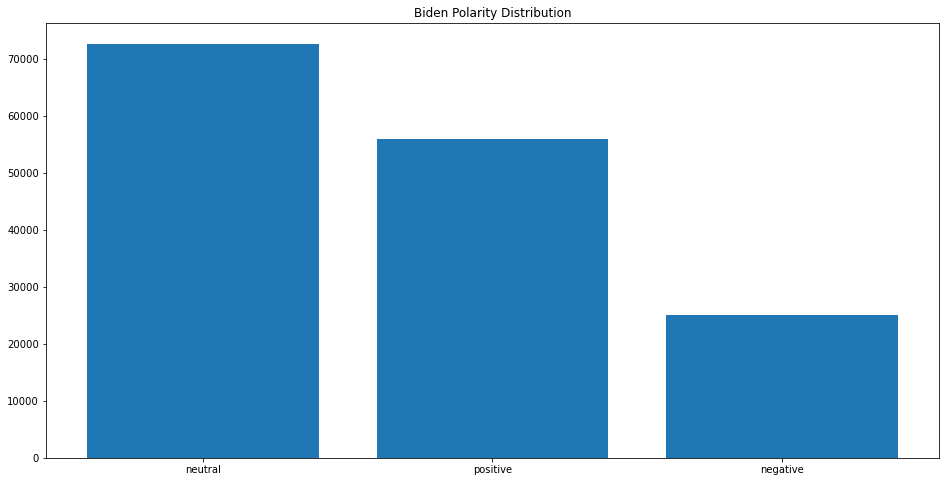

In [30]:
#Chart Polarity Distribution
from collections import Counter

target_cnt = Counter(biden_tweets.analysis)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Biden Polarity Distribution")

In [31]:
#Chart Sentiment Distribution
general  = biden_tweets.groupby('analysis').analysis.count()
neutral  = biden_tweets[biden_tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = biden_tweets[biden_tweets['analysis'] == 'positive'].ClearTweet.count()
negative = biden_tweets[biden_tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positive","negative","neutral"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentiment analysis  Joe Biden Tweets')
fig.show()

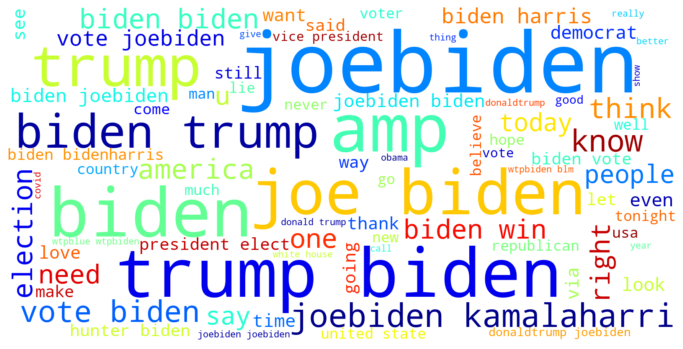

In [32]:
#Plot Biden wordcloud
word_cloud(biden_tweets['ClearTweet'])